# 🛑 Complete los siguientes datos

- Nombre y Apellidos: Katrin Muñoz Errasti
- Entrega: Entrega 06 - Mountain Car
- Fecha: 07/01/2026
- Tiempo dedicado a la entrega: aproximadamente 10 horas dividido en diferentes sesiones
- Principales dudas y dificultades encontrados en el desarrollo:

  * Uno de los mayores problemas fue estabilizar el aprendizaje. Inicialmente probé con una tasa de aprendizaje de 0.01, pero esto provocaba que el modelo oscilara drásticamente sin converger, manteniéndose estancado en una recompensa de -200 (fallo constante). Fue necesario reducirlo a 4e-3 para conseguir que el agente aprendiera a salir del valle de forma consistente.

  * En los primeros intentos, perdía los mejores pesos de la red porque el script solo guardaba el modelo al finalizar todos los pasos. A veces, el modelo final era peor que uno intermedio. Esto lo solucioné implementando Callbacks (`EvalCallback`) para guardar automáticamente el `best_model` y detener el entrenamiento (*early stopping*) cuando se detectaba convergencia, reduciendo el tiempo de cómputo de 20 a 6 minutos aproximadamente.

  * Me costó ajustar la rejilla BUCKETS porque influye mucho en el aprendizaje. Con muy pocos buckets el agente no ve bien la diferencia entre estados (pierde información) y con demasiados buckets la Q-table se vuelve enorme y tarda mucho más en aprender.

  *  Al principio, el agente tardaba hasta 10 minutos en encontrar la cima por primera vez, desperdiciando mucho cómputo. Al ajustar la fracción de exploración, logré que descubriera la meta mucho antes (en un par de minutos), acelerando todo el ciclo de aprendizaje.

## Instrucciones generales

### Contexto de la práctica, preliminares e instrucciones

Este es el cuaderno que utilizarás como **plantilla** para entrega de la asignatura Laboratorio de IA del tema correspondiente.

La práctica está **alineada** con las sesiones de teoría y el ejemplo de código visto en el aula, por lo que es recomendable un repaso al material del tema previo a la implementación de la práctica.

Por favor, **lee atentamente** el enunciado. Si tienes alguna duda, utiliza el foro o ponte en contacto con el profesor (pero no compartas código).

Consideraciones generales sobre el código:
- Utilice tantas celdas (de texto o de código) como considere para dar una respuesta legible y clara a las preguntas planteadas.
- Mostrar resultados intermedios o finales (tablas, contenido de las variables...) que demuestren que la solución es correcta si fuera necesario.
- No olvide importar todas las librerías necesarias para la correcta ejecución del código, incluyendo la instalación de las mismas, si fuera necesario.


### Para entregar el cuaderno:
- Imprímelo en un archivo PDF con todas las secciones expandidas y todas las celdas ejecutadas, de forma que se pueda ver todo el código y se muestren todos los resultados.
- Guardar el cuaderno como archivo ipynb.

Envía ambos archivos en una carpeta zip a ALUD. Nombre los ficheros con su nombre, apellidos y el número de práctica.

### Evaluación: Esta práctica cuenta un 12.5% de la evaluación final de la asignatura.

En las indicaciones, hay instrucciones extra indicadas con el símbolo 🤖. No son requisitos para superar la práctica, sino acciones que puedes realizar para mejorar la calificación.

La calificación de los ejercicios se hará con los siguientes criterios:
- [9 a 10] puntos: La solución aportada cumple con los requisitos de forma excelente y existen aspectos positivos o extras (🤖) que avalan su excelencia.
- [7 a 9] puntos: La solución aportada cumple con los requisitos, pero algunas cuestiones menores son susceptibles de ser mejoradas, tales como: presentación de la solución, justificación de la decisión tomada, eficiencia del código...
- [5 a 7] puntos: Las soluciones aportadas no cumplen alguno de los requisitos, como por ejemplo: no se responde a una pregunta, no se aporta la solución a una parte...
- [1 a 5] puntos: La solución aportada no cumple con varios requisitos.
- [0] puntos: solución no aportada o solución plagiada.

La limpieza y la eficiencia del código, así como las explicaciones dadas serán tenidas en cuenta  para la evaluación.

### Plazo:

El plazo de entrega de la práctica son dos semanas tras la presentación de la misma en el aula.

Tenga presente que la práctica puede entregarse pasado el plazo dado, en cualquier momento del cuatrimestre, teniendo en cuenta que, la entrega pasado el plazo será evaluada sobre el 75% de la calificación.

# 🛑 Desarrollo a realizar

A lo largo de las próximas celdas, tendrá que implementar una política que permita resolver el escenario de MountainCar dentro del OpenAI Gym.


**Requisitos básicos**
 - El coche llega a lo alto de la montaña.

**Consideraciones deseables**
 - Se hace en el menor número de pasos posibles.

**🤖Requisitos extra**
 - Utilizar un algoritmo de Deep Reinforcement Learning para resolver el escenario.


# Mountain Car

En este cuaderno vamos a programar a mano para conseguir resolver este entorno.

![](https://cdn-images-1.medium.com/max/800/0*VsDhkvrcaTOc2bwu.gif)

Recordad que los elementos que tenemos para resolver este problema:
- El entorno del coche provee las siguientes acciones discretas:
  - 0 - Aplicar fuerza a la izquierda
  - 1 - No aplicar fuerza
  - 2 - Aplicar fuerza a la derecha

- Para evaluar el entorno, tenemos los siguientes valores continuos:
  - state[0]: Posición
  - state[1]: Velocidad

Para ello, vamos a definir primeramente el entorno

# 0. Modo de resolución elegido

En esta práctica se resuelve el entorno **MountainCar-v0**, donde el objetivo es que el coche llegue a la cima de la colina de la derecha. El entorno tiene:

* **Acciones discretas (3):** empujar a la izquierda, no empujar, empujar a la derecha.
* **Estado continuo (2D):** `posición` y `velocidad`.

La dificultad está en que el motor no tiene fuerza suficiente para subir del tirón, así que el agente debe aprender la estrategia clave: balancearse (ir hacia atrás para ganar velocidad y luego subir).

En cuanto a la recompensa, el entorno es de recompensa escasa:

* En general, cada paso penaliza (**-1 por paso**), el objetivo es que el agente quiere llegue en el menor número de pasos posible.
* El episodio termina cuando alcanza la meta (posición ≥ 0.5) o cuando se llega al máximo de pasos (-200.0) permitido.

Con esto en mente, se implementan dos enfoques: primero uno clásico (Q-Learning tabular) y después uno DQN que trabaja directamente con el estado continuo.

## 0.1 Enfoque 1 — Q-Learning manual (tabla Q discreta)

Se aplica **Q-Learning tabular**, pero como el estado es continuo, se discretiza (posición y velocidad) en una rejilla (buckets).
Este enfoque permite ver de forma clara cómo se actualizan los valores Q(s,a) mediante la ecuación de Bellman, y sirve como línea base para comparar rendimiento y estabilidad.

## 0.2 Enfoque 2 — Deep Reinforcement Learning (DQN)

Se utiliza un DQN (Deep Q-Network) con *Stable-Baselines3*, que evita discretizar y aprende directamente sobre el estado continuo:

* Una red neuronal MLP aproxima la función Q.

* La política es epsilon-greedy: al principio explora mucho y luego va explotando lo aprendido.

* El entrenamiento se realiza durante un número fijo de interacciones y se valida con episodios de evaluación independientes.

En resumen, la práctica compara un método clásico (Q-Learning con discretización) frente a un enfoque moderno (DQN), analizando no solo si llega a la cima, sino también cuántos pasos necesita y con qué consistencia.

# **1. Preparación del entorno**

En esta sección se prepara el entorno para poder ejecutar la práctica tanto en local como en Colab: se importan las librerías generales (gestión de ficheros, cálculo y visualización) y se detecta automáticamente si se está ejecutando en **Google Colab** o en un entorno **local**.

* Si es Colab, se instalan los paquetes necesarios para renderizar y grabar vídeo sin pantalla y se arranca un display virtual para que el wrapper `RecordVideo` funcione correctamente.

* Si es local, no se instala nada automáticamente y se asume que el entorno ya tiene las dependencias configuradas.

Además, al final de la celda se cargan también las librerías específicas de Reinforcement Learning (Gymnasium + Stable-Baselines3) y las utilidades para mostrar vídeos dentro del cuaderno.


## 1.1 Instalación de dependencias y carga de librerías (Colab vs local)

Esta celda hace dos cosas:

Primero, detecta si el notebook se ejecuta en Google Colab. Si lo es, instala dependencias para poder renderizar y grabar vídeos sin monitor. Después, inicializa un Display virtual para que el renderizado funcione en segundo plano dentro de Colab.

Si no es Colab, se asume un entorno local y no se instala nada automáticamente.

Segundo, importa las librerías principales del proyecto: utilidades de ficheros, cálculo, visualización y las librerías de RL necesarias para entrenar y grabar. Por último, configura `warnings` para evitar mensajes innecesarios.

In [11]:
# Detección de entorno (Colab vs Local)
try:
    import google.colab
    EsColab = True
    print("Entorno Google Colab detectado. Instalando dependencias gráficas...")

    # Instalación de dependencias del sistema y librerías de Python
    !sudo apt-get update -y > /dev/null
    !sudo apt-get install -y xvfb ffmpeg x11-utils > /dev/null
    !pip install -q pyvirtualdisplay gymnasium "stable-baselines3[extra]" shimmy moviepy

    # Iniciar display virtual
    from pyvirtualdisplay import Display
    _display = Display(visible=False, size=(1400, 900))
    _display.start()
    print("Dependencias instaladas y Display virtual iniciado.")

except ImportError:
    EsColab = False
    print("Entorno local detectado. Se asume que las dependencias están instaladas.")

# Librerías generales
import os
import shutil
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Librerías de Reinforcement Learning
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

# Librerías de isualización de video
from IPython.display import Video, display

# Filtrar avisos
import warnings
warnings.filterwarnings("ignore")

Entorno Google Colab detectado. Instalando dependencias gráficas...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Dependencias instaladas y Display virtual iniciado.


## 1.2 Configuración visual, constantes globales, hiperparámetros y directorios

Esta celda define la configuración del experimento.

* **Estilo visual**: se fija un estilo de `matplotlib` y colores para diferenciar enfoques (Q-Learning vs DQN) en las gráficas.

* **Constantes globales**: se define el entorno (`MountainCar-v0`) y una semilla (`SEMILLA`) para reproducibilidad.

* **Hiperparámetros de Q-Learning**

* **Hiperparámetros de DQN**

* **Gestión de directorios**: se definen carpetas para logs y vídeos, rutas para guardar modelos, y se hace una limpieza inicial borrando cualquier ejecución previa para no mezclar resultados, recreando las carpetas desde cero.

In [12]:
# ESTILOS VISUALES
plt.style.use("seaborn-v0_8-whitegrid")
COLOR_QL = "#1f77b4"  # Azul enfoque Manual
COLOR_DQN = "#2ca02c" # Verde enfoque Deep Learning

# CONSTANTES GLOBALES
ID_ENTORNO = "MountainCar-v0"
SEMILLA = 42

# HIPERPARÁMETROS Q-LEARNING (Manual)
EPISODIOS_QL = 15_000
ALPHA_QL = 0.1       # Tasa de aprendizaje
GAMMA_QL = 0.99      # Factor de descuento (importancia del futuro)
EPSILON_INIT_QL = 1.0
EPSILON_MIN_QL = 0.01
BUCKETS = (20, 20)   # Discretización (Posición, Velocidad)

# HIPERPARÁMETROS DQN
PASOS_TOTALES_DQN = 200_000
TASA_APRENDIZAJE_DQN = 4e-3
TAMANO_LOTE = 128
BUFFER_SIZE = 50_000
GAMMA_DQN = 0.99
FREQ_ENTRENAMIENTO = 16
PASOS_GRADIENTE = 8
EXPLORACION_FRACCION = 0.2
RED_ARQUITECTURA = [256, 256]

# GESTIÓN DE DIRECTORIOS
CARPETA_LOGS = "logs_mountaincar"
CARPETA_VIDEO = "video_evidencia"
RUTA_MEJOR_MODELO = os.path.join(CARPETA_LOGS, "best_model")
RUTA_MODELO_FINAL = os.path.join(CARPETA_LOGS, "modelo_final")

# Limpieza inicial para evitar mezclar experimentos previos
for carpeta in [CARPETA_LOGS, CARPETA_VIDEO]:
    if os.path.exists(carpeta):
        shutil.rmtree(carpeta)
    os.makedirs(carpeta, exist_ok=True)

print(f"Configuración cargada.\n  Logs: {CARPETA_LOGS}\n  Video: {CARPETA_VIDEO}")

Configuración cargada.
  Logs: logs_mountaincar
  Video: video_evidencia


## **2. Funciones auxiliares**

En este apartado se agrupan funciones reutilizables que simplifican el resto del cuaderno y evitan repetir código en cada experimento.

* Creación del entorno con semilla, logs (`Monitor`) y/o grabación de vídeo (`RecordVideo`).

* Discretización del estado continuo (posición/velocidad) para poder aplicar Q-Learning.

* Función para mostrar el último vídeo generado en el cuaderno.

* Función de visualización con curva cruda + media móvil para ver tendencias de aprendizaje.

## 2.1 CrearEntorno

Esta función centraliza la creación del entorno `MountainCar-v0` para asegurar coherencia entre entrenamiento, evaluación y generación de evidencias.

Permite:

* Activar renderizado (`render_mode`) y, si se graba vídeo, forzar `rgb_array`.

* Grabar evidencias con `RecordVideo` en `CARPETA_VIDEO` usando un prefijo.

* Registrar logs con `Monitor` (DQN para guardar métricas por episodio).

* Fijar semilla para reproducibilidad.

In [13]:
def CrearEntorno(render_mode=None, seed=None, monitor_dir=None, record_video=False, video_prefix="demo"):
    """
    Crea el entorno con la configuración adecuada para Entrenamiento o Evaluación.
    """
    if record_video:
        render_mode = "rgb_array"

    env = gym.make(ID_ENTORNO, render_mode=render_mode)

    # Wrapper para grabar video
    if record_video:
        env = RecordVideo(
            env,
            video_folder=CARPETA_VIDEO,
            episode_trigger=lambda x: True,
            name_prefix=video_prefix
        )

    # Wrapper para logs de entrenamiento (DQN)
    if monitor_dir:
        os.makedirs(monitor_dir, exist_ok=True)
        env = Monitor(env, monitor_dir)

    if seed is not None:
        env.reset(seed=seed)
        env.action_space.seed(seed)

    return env

## 2.2 DiscretizarEstado

Convierte el estado continuo del entorno (posición y velocidad) en un par de índices discretos según una rejilla. Esto es necesario para poder usar una tabla Q en Q-Learning, ya que la observación original es continua.

La discretización se hace:

* Calculando el rango de cada dimensión (`high - low`).
* Dividiendo ese rango en “buckets” (rejillas).
* Transformando el estado real en el índice de celda correspondiente.
* Asegurarando que los índices no se salen de los límites.

In [14]:
def DiscretizarEstado(env, estado, buckets):
    """
    Convierte el estado continuo (posición, velocidad) a índices discretos
    para poder usarlos en la tabla Q.
    """
    rango = (env.observation_space.high - env.observation_space.low)
    ventana = rango / np.array(buckets)
    estado_disc = (estado - env.observation_space.low) / ventana
    return tuple(estado_disc.astype(int).clip(0, np.array(buckets) - 1))

## 2.3 MostrarUltimoVideo

Busca en `CARPETA_VIDEO` el último archivo `.mp4` generado y lo muestra embebido en el notebook usando `IPython.display.Video`.

Si no hay vídeos, imprime un mensaje indicando que no se han encontrado.

In [15]:
def MostrarUltimoVideo():
    """ Busca y muestra el último video generado en la carpeta de videos """
    lista_videos = glob.glob(os.path.join(CARPETA_VIDEO, "*.mp4"))
    if lista_videos:
        # Mostrar el más reciente
        ultimo = max(lista_videos, key=os.path.getctime)
        print(f"Mostrando evidencia: {os.path.basename(ultimo)}")
        display(Video(ultimo, embed=True))
    else:
        print("No se encontraron videos.")

## 2.4 GraficarResultados

Función de visualización para interpretar el aprendizaje. Dibuja:

* **Curva cruda**: recompensa por episodio/timestep.
* **Media móvil**: tendencia suavizada con ventana para ver si realmente mejora.

In [16]:
def GraficarResultados(x, y, titulo, color_main, window=50):
    """
    Grafica curva cruda y media móvil para visualizar tendencias de aprendizaje.
    """
    plt.figure(figsize=(12, 5))

    # Curva cruda (transparente)
    plt.plot(x, y, alpha=0.3, color=color_main, label="Recompensa por episodio (Cruda)")

    # Media móvil (Sólida)
    if len(y) >= window:
        y_smooth = np.convolve(y, np.ones(window)/window, mode='valid')
        x_smooth = x[window-1:]
        plt.plot(x_smooth, y_smooth, color=color_main, linewidth=2.5, label=f"Tendencia (Media móvil {window})")

    plt.title(titulo, fontsize=14, fontweight='bold')
    plt.xlabel("Progreso de entrenamiento")
    plt.ylabel("Recompensa")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## 3. Q-Learning manual (tabla Q)

En este apartado se implementa un Q-Learning tabular clásico para `MountainCar-v0`, discretizando el estado (posición/velocidad) en una rejilla (`BUCKETS`).

## 3.1 Entrenamiento del agente con Q-Learning (Epsilon-Greedy + Bellman)

En esta celda se entrena el agente mediante:

* **Inicialización optimista** de la Q-table, es decir, uso valores ligeramente negativos para favorecer exploración al inicio.

* **Política *epsilon-greedy***: con probabilidad `epsilon` el agente explora eligiendo una acción al azar; en caso contrario, explota seleccionando la acción con mayor valor Q en la tabla.

* Actualización con la ecuación de Bellman.

Además, se aplica un decremento de epsilon hasta `EPSILON_MIN_QL` para pasar gradualmente de explorar a explotar. Para monitorizar progreso, se imprime cada 2000 episodios la recompensa media reciente y al final se dibuja una gráfica con curva cruda + media móvil.


In [17]:
print("\033[1mEntrenamiento Q-Learning Manual\033[0m")

# Inicializar entorno
env_ql = CrearEntorno(seed=SEMILLA)

# Inicializar la tabla Q (Optimistic Initialization)
q_table = np.random.uniform(low=-2, high=0, size=(BUCKETS + (env_ql.action_space.n,)))

historial_ql = []
epsilon = EPSILON_INIT_QL
# Cálculo lineal del decaimiento
decay = (EPSILON_INIT_QL - EPSILON_MIN_QL) / (EPISODIOS_QL * 0.7)

start_time = datetime.now()

for episodio in range(EPISODIOS_QL):
    estado_raw, _ = env_ql.reset()
    estado = DiscretizarEstado(env_ql, estado_raw, BUCKETS)
    done = False
    total_reward = 0

    while not done:
        # Elegir acción (Epsilon-Greedy)
        if np.random.random() > epsilon:
            accion = np.argmax(q_table[estado]) # Explotación
        else:
            accion = env_ql.action_space.sample() # Exploración

        # Ejecutar acción
        next_raw, reward, terminated, truncated, _ = env_ql.step(accion)
        done = terminated or truncated
        next_estado = DiscretizarEstado(env_ql, next_raw, BUCKETS)

        # Actualizar Tabla Q (Bellman)
        if not done:
            max_future_q = np.max(q_table[next_estado])
            current_q = q_table[estado + (accion,)]
            new_q = (1 - ALPHA_QL) * current_q + ALPHA_QL * (reward + GAMMA_QL * max_future_q)
            q_table[estado + (accion,)] = new_q
        elif terminated and next_raw[0] >= 0.5:
            # Recompensa artificial al llegar a la meta para acelerar convergencia
            q_table[estado + (accion,)] = 0

        estado = next_estado
        total_reward += reward

    # Reducir exploración
    if epsilon > EPSILON_MIN_QL:
        epsilon -= decay

    historial_ql.append(total_reward)

    # Log periódico
    if (episodio + 1) % 2000 == 0:
        media_reciente = np.mean(historial_ql[-100:])
        print(f"  Episodio {episodio+1}: Recompensa media (últimos 100): {media_reciente:.2f}")

env_ql.close()
duracion = datetime.now() - start_time
print(f"\n\nEntrenamiento de Q-Learning listo. Tiempo total: {duracion}")

Entrenamiento Q-Learning Manual
  Episodio 2000: Recompensa media (últimos 100): -200.00
  Episodio 4000: Recompensa media (últimos 100): -200.00
  Episodio 6000: Recompensa media (últimos 100): -199.75
  Episodio 8000: Recompensa media (últimos 100): -183.39
  Episodio 10000: Recompensa media (últimos 100): -175.33
  Episodio 12000: Recompensa media (últimos 100): -170.60
  Episodio 14000: Recompensa media (últimos 100): -149.34


Entrenamiento de Q-Learning listo. Tiempo total: 0:03:54.673689


## 3.2 Evaluación del Q-Learning

Tras entrenar, se evalúa la política aprendida en modo sin exploración: siempre se elige `argmax` en la Q-table.
La evaluación se hace en un entorno con semilla distinta para no “memorizar” exactamente la misma secuencia.

Durante `num_episodes` episodios se registran y muestran las siguientes **métricas**:

* **Tasa de éxito**: número de episodios que finalizan por `terminated` (alcanzar la meta).
* **Recompensa media**: promedio de la recompensa total por episodio.
* **Pasos medios**: promedio de pasos necesarios por episodio.

Además, se generan cuatro visualizaciones para interpretar el comportamiento del agente:

1. **Curva de aprendizaje** recompensa durante el entrenamiento con media móvil para ver la tendencia.

2. **Barras de recompensa por episodio** en evaluación, para comprobar consistencia.

3. **Evolución de pasos por episodio**, para medir eficiencia, si llega antes o se acerca al máximo.

4. **Mapa de política aprendida** (heatmap), que muestra qué acción (izquierda / nada / derecha) elige el agente en cada celda de la rejilla.



Evaluación Q-Learning (Manual) en 20 episodios
Tasa de éxito: 20/20 (100.0%)
Recompensa media: -179.05
Pasos medios: 179.05


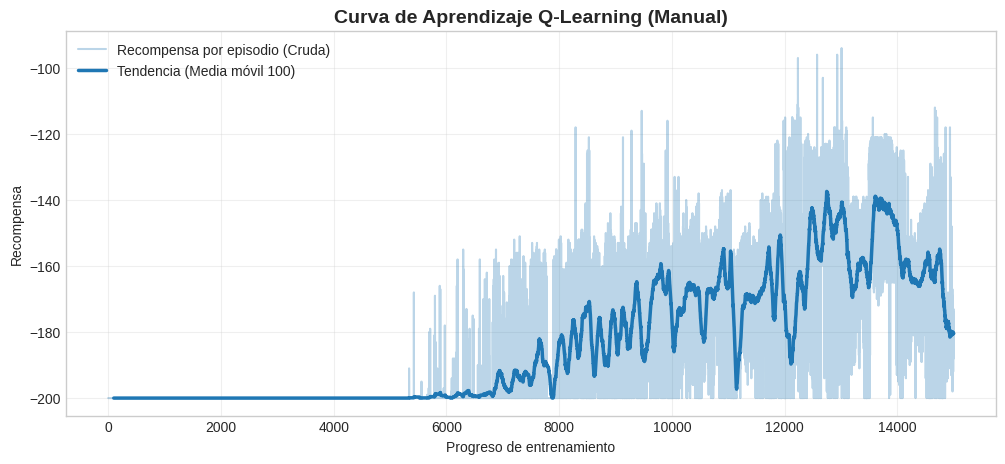

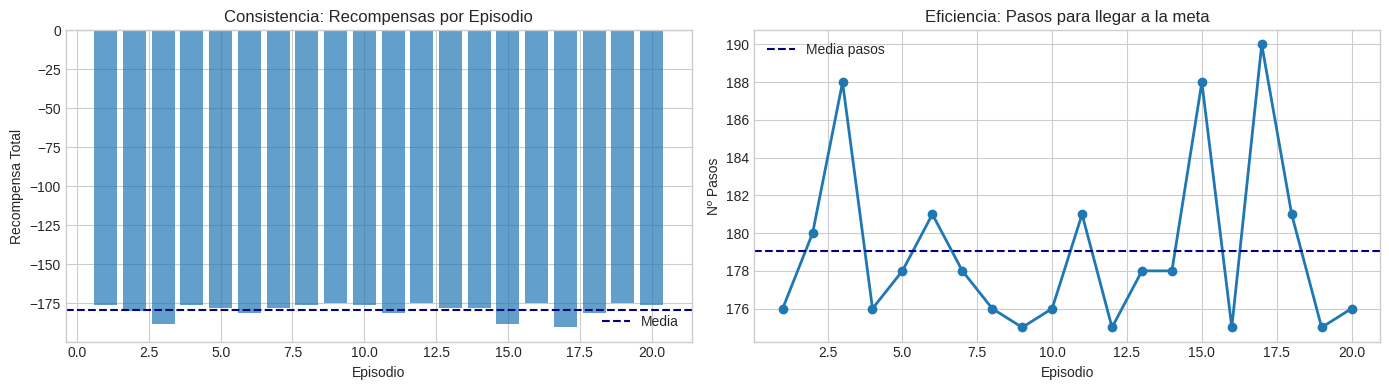

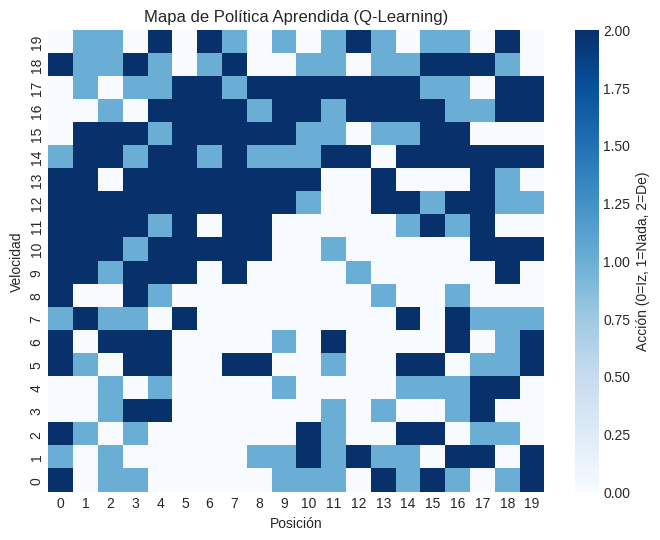

In [18]:
def EvaluarAgenteManual(q_table_trained, buckets, num_episodes=20):
    """
    Evalúa la política de la tabla Q sin exploración.
    """
    env_test = CrearEntorno(seed=SEMILLA + 200)
    recompensas = []
    pasos = []
    exitos = 0

    print(f"\n\033[1mEvaluación Q-Learning (Manual) en {num_episodes} episodios\033[0m")

    for i in range(num_episodes):
        obs, _ = env_test.reset()
        estado = DiscretizarEstado(env_test, obs, buckets)
        done = False
        total_r = 0
        steps = 0

        while not done:
            # Política Greedy pura: siempre se elige la mejor acción de la tabla
            action = np.argmax(q_table_trained[estado])

            obs, reward, terminated, truncated, _ = env_test.step(action)
            estado = DiscretizarEstado(env_test, obs, buckets)

            total_r += reward
            steps += 1
            done = terminated or truncated

        recompensas.append(total_r)
        pasos.append(steps)
        if terminated: exitos += 1

    env_test.close()

    # Métricas Numéricas
    print(f"Tasa de éxito: {exitos}/{num_episodes} ({(exitos/num_episodes)*100:.1f}%)")
    print(f"Recompensa media: {np.mean(recompensas):.2f}")
    print(f"Pasos medios: {np.mean(pasos):.2f}")

    # Gráfica de Aprendizaje
    GraficarResultados(np.arange(len(historial_ql)), historial_ql,
                   "Curva de Aprendizaje Q-Learning (Manual)", COLOR_QL, window=100)


    # Gráficas Comparativas
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    # Gráfica de Recompensas
    ax1.bar(range(1, num_episodes+1), recompensas, color=COLOR_QL, alpha=0.7)
    ax1.axhline(np.mean(recompensas), color='navy', linestyle='--', label='Media')
    ax1.set_title("Consistencia: Recompensas por Episodio")
    ax1.set_xlabel("Episodio")
    ax1.set_ylabel("Recompensa Total")
    ax1.legend()

    # Gráfica de Pasos
    ax2.plot(range(1, num_episodes+1), pasos, marker='o', color=COLOR_QL, linewidth=2)
    ax2.axhline(np.mean(pasos), color='navy', linestyle='--', label='Media pasos')
    ax2.set_title("Eficiencia: Pasos para llegar a la meta")
    ax2.set_xlabel("Episodio")
    ax2.set_ylabel("Nº Pasos")
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Obtener la mejor acción para cada estado
    politica = np.argmax(q_table_trained, axis=2)

    # Gráfica visualizar política (mapa de calor)
    plt.figure(figsize=(8, 6))
    sns.heatmap(politica.T, cmap="Blues", annot=False, cbar_kws={'label': 'Acción (0=Iz, 1=Nada, 2=De)'})
    plt.title("Mapa de Política Aprendida (Q-Learning)")
    plt.xlabel("Posición")
    plt.ylabel("Velocidad")
    plt.gca().invert_yaxis()
    plt.show()

# Ejecutar Evaluación
EvaluarAgenteManual(q_table, BUCKETS)

## 3.3 Generación de evidencia en vídeo (demo Q-Learning)

Finalmente, se crea un entorno con `RecordVideo` y se ejecutan 3 episodios usando la política greedy aprendida (sin epsilon), grabando evidencias en `.mp4` dentro de `CARPETA_VIDEO`.

Al cerrar el entorno, se muestra automáticamente el último vídeo generado en el cuaderno, dejando una prueba visual directa del comportamiento del agente entrenado.

In [19]:
print("Video de evidencia (Q-Learning Manual)")

env_video_ql = CrearEntorno(record_video=True, video_prefix="manual_ql_demo", seed=SEMILLA+777)

for i in range(3):
    obs, _ = env_video_ql.reset()
    estado = DiscretizarEstado(env_video_ql, obs, BUCKETS)
    done = False

    while not done:
        action = np.argmax(q_table[estado])
        obs, _, terminated, truncated, _ = env_video_ql.step(action)
        estado = DiscretizarEstado(env_video_ql, obs, BUCKETS)
        done = terminated or truncated

env_video_ql.close()

# Mostrar resultado en el cuaderno
MostrarUltimoVideo()

Video de evidencia (Q-Learning Manual)
Mostrando evidencia: manual_ql_demo-episode-3.mp4


## **4. DQN (Deep Q-Network)**

En este apartado se entrena un agente **DQN** usando Stable-Baselines3, con una red neuronal que aproxima la función Q. A diferencia del Q-Learning tabular (que necesita discretizar), aquí el modelo trabaja directamente con el estado continuo del entorno, y se apoya en replay buffer, red objetivo y una política de exploración programada.

## 4.1 Entrenamiento del DQN

La celda primero crea dos entornos distintos:

- `env_train`: entorno de entrenamiento con `Monitor` activado para guardar logs en `CARPETA_LOGS`.

- `env_eval`: entorno de evaluación sin monitorización para validar periódicamente.

Después, se configuran callbacks para automatizar el proceso:

- `StopTrainingOnRewardThreshold`: detiene el entrenamiento cuando la recompensa media supera el umbral fijado (`-110`).

- `EvalCallback`: cada 5000 pasos evalúa el agente en `env_eval` y, si encuentra un modelo mejor, guarda el checkpoint como `best_model` en `CARPETA_LOGS`. Además, enlaza la parada temprana cuando aparece un nuevo mejor modelo.

Con esto se evita depender del último checkpoint y se conserva el mejor modelo observado durante validación.


In [20]:
print("\033[1mEntrenamiento DQN (Deep Q-Network)\033[0m")

# Crear entornos separados
env_train = CrearEntorno(seed=SEMILLA, monitor_dir=CARPETA_LOGS)
env_eval = CrearEntorno(seed=SEMILLA+1)

# Configurar Callbacks
# Callback de parada: Si la recompensa media supera -110, consideramos el problema resuelto
stop_callback = StopTrainingOnRewardThreshold(reward_threshold=-110, verbose=1)

# Callback de evaluación: Cada 5000 pasos prueba el agente y guarda el mejor modelo
eval_callback = EvalCallback(
    env_eval,
    best_model_save_path=CARPETA_LOGS,
    log_path=CARPETA_LOGS,
    eval_freq=5000,
    n_eval_episodes=5,
    deterministic=True,
    render=False,
    callback_on_new_best=stop_callback,
    verbose=1
)

# Instanciación del Modelo DQN
model_dqn = DQN(
    "MlpPolicy",
    env_train,
    learning_rate=TASA_APRENDIZAJE_DQN,
    batch_size=TAMANO_LOTE,
    buffer_size=BUFFER_SIZE,
    learning_starts=1000,
    gamma=GAMMA_DQN,
    target_update_interval=600,
    train_freq=FREQ_ENTRENAMIENTO,
    gradient_steps=PASOS_GRADIENTE,
    exploration_fraction=EXPLORACION_FRACCION,
    exploration_final_eps=0.01,
    policy_kwargs=dict(net_arch=RED_ARQUITECTURA),
    seed=SEMILLA,
    verbose=0
)

# Ejecutar aprendizaje
start_time = datetime.now()
model_dqn.learn(total_timesteps=PASOS_TOTALES_DQN, callback=eval_callback)
training_time = datetime.now() - start_time

# Guardar también el modelo del último paso
model_dqn.save(RUTA_MODELO_FINAL)
env_train.close()
env_eval.close()

print(f"\nEntrenamiento DQN finalizado.")
print(f"Tiempo total: {training_time}")
print(f"Mejor modelo disponible en: {RUTA_MEJOR_MODELO}.zip")

Entrenamiento DQN (Deep Q-Network)
Eval num_timesteps=5000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
New best mean reward!
Eval num_timesteps=10000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=15000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=20000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=25000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=30000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=35000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=45000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=55000, episode_reward=-20

## 4.2 Configuración del modelo, registro de métricas y selección del mejor checkpoint

Se instancia `DQN("MlpPolicy", ...)` usando los hiperparámetros optimizados definidos al inicio:

* `learning_rate`, `batch_size`, `buffer_size`, `gamma`, frecuencias de entrenamiento y pasos de gradiente.
* Parámetros de exploración: `exploration_fraction` y `exploration_final_eps`.
* Arquitectura de red (`net_arch=RED_ARQUITECTURA`) para capturar mejor la dinámica del problema.

Tras `learn()`, se guarda también el modelo final por seguridad (`RUTA_MODELO_FINAL`) y se cierran los entornos.

Luego, si hay logs del `Monitor`, se cargan para generar la curva de aprendizaje y visualizar la tendencia con `GraficarResultados`.

Por último, se decide qué modelo usar para el resto del cuaderno:

* Si existe `best_model.zip`, se carga ese (mejor rendimiento en validación).
* Si no existe, se carga el modelo final guardado (fallback).

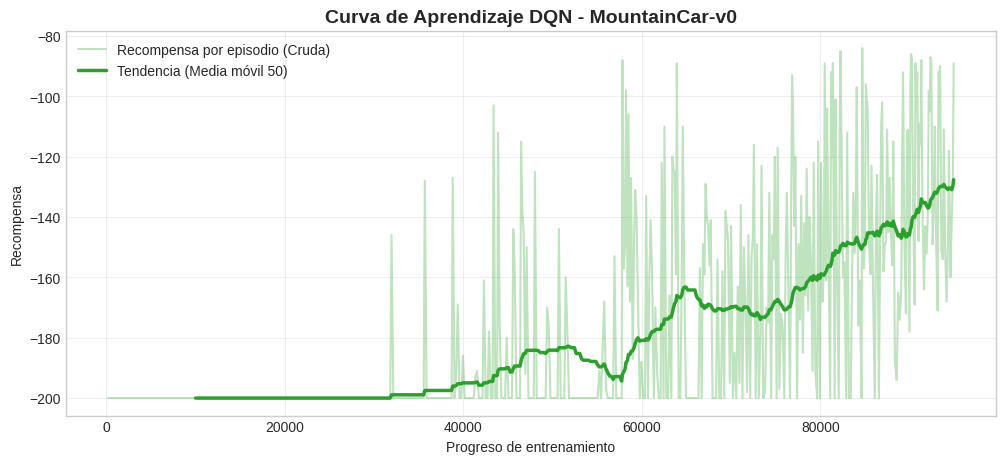

Cargando MEJOR modelo DQN desde: logs_mountaincar/best_model.zip


In [21]:
# Cargar datos del monitor
try:
    results = load_results(CARPETA_LOGS)
    x_dqn, y_dqn = ts2xy(results, "timesteps")

    GraficarResultados(x_dqn, y_dqn,
                       f"Curva de Aprendizaje DQN - {ID_ENTORNO}",
                       COLOR_DQN, window=50)
except Exception as e:
    print(f"No se pudieron cargar los logs de monitorización: {e}")

# Cargar el mejor modelo disponible (el que obtuvo mejor puntuación en validación)
ruta_carga = RUTA_MEJOR_MODELO + ".zip"
if os.path.exists(ruta_carga):
    print(f"Cargando MEJOR modelo DQN desde: {ruta_carga}")
    final_model = DQN.load(ruta_carga)
else:
    print(f"Aviso: 'best_model' no encontrado. Cargando modelo FINAL.")
    final_model = DQN.load(RUTA_MODELO_FINAL)


## 4.3 Evaluación y evidencia en vídeo (DQN)

Se define `EvaluarAgenteDQN`, que ejecuta el modelo en modo **determinista** (`modelo.predict(..., deterministic=True)`) durante `num_episodes` episodios, midiendo:

* **Tasa de éxito** (episodios que terminan por `terminated`).
* **Recompensa media**.
* **Pasos medios** por episodio (eficiencia).

Además, se generan dos gráficas comparativas:

* Recompensas por episodio (consistencia).
* Pasos por episodio (eficiencia).

Finalmente, se graba evidencia visual:

* Se crea un entorno con `record_video=True`.
* Se ejecutan 3 episodios con el `final_model` determinista.
* Se guarda el vídeo en `CARPETA_VIDEO` y se muestra el último `.mp4` en el notebook con `MostrarUltimoVideo()`.

Así queda una demo clara y verificable del comportamiento del agente DQN entrenado.


Evaluando DQN en 20 episodios...
Tasa de éxito: 20/20 (100.0%)
Recompensa media: -98.15
Pasos medios: 98.15


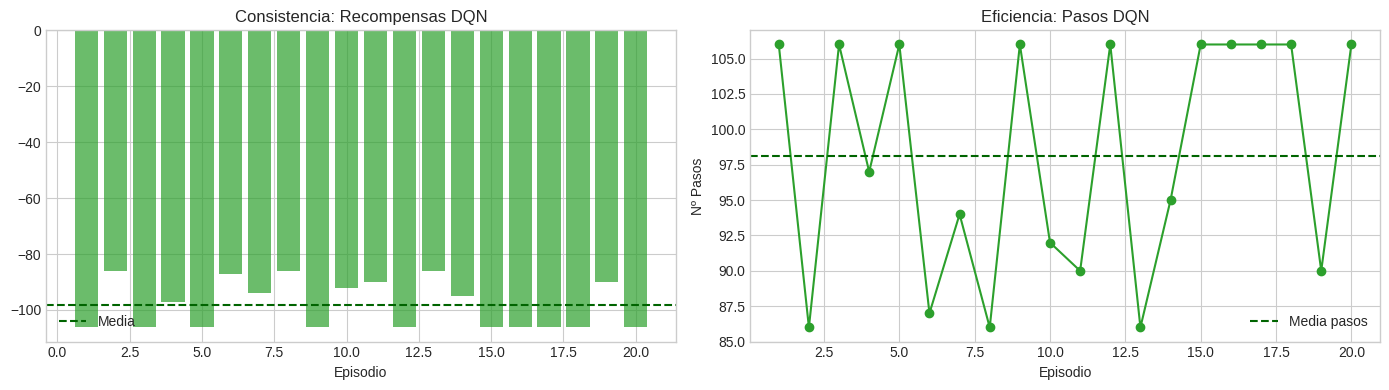

Video de evidencia (DQN Optimizado)...
Videos guardados en video_evidencia
Mostrando evidencia: dqn_optimized_demo-episode-3.mp4


In [22]:
def EvaluarAgenteDQN(modelo, num_episodes=20):
    """
    Evalúa el modelo DQN cargado.
    """
    env_test = CrearEntorno(seed=SEMILLA+999)
    recompensas = []
    pasos = []
    exitos = 0

    print(f"\nEvaluando DQN en {num_episodes} episodios...")
    for i in range(num_episodes):
        obs, _ = env_test.reset()
        done = False
        total_r = 0
        steps = 0

        while not done:
            action, _ = modelo.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env_test.step(int(action))
            total_r += reward
            steps += 1
            done = terminated or truncated

        recompensas.append(total_r)
        pasos.append(steps)
        if terminated: exitos += 1

    env_test.close()

    # Métricas Numéricas
    print(f"Tasa de éxito: {exitos}/{num_episodes} ({(exitos/num_episodes)*100:.1f}%)")
    print(f"Recompensa media: {np.mean(recompensas):.2f}")
    print(f"Pasos medios: {np.mean(pasos):.2f}")

    # Gráficas Comparativas
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    # Recompensas
    ax1.bar(range(1, num_episodes+1), recompensas, color=COLOR_DQN, alpha=0.7)
    ax1.axhline(np.mean(recompensas), color='darkgreen', linestyle='--', label='Media')
    ax1.set_title("Consistencia: Recompensas DQN")
    ax1.set_xlabel("Episodio")
    ax1.legend()

    # Pasos
    ax2.plot(range(1, num_episodes+1), pasos, marker='o', color=COLOR_DQN)
    ax2.axhline(np.mean(pasos), color='darkgreen', linestyle='--', label='Media pasos')
    ax2.set_title("Eficiencia: Pasos DQN")
    ax2.set_xlabel("Episodio")
    ax2.set_ylabel("Nº Pasos")
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Ejecutar evaluación DQN
EvaluarAgenteDQN(final_model)

print("Video de evidencia (DQN Optimizado)...")

# Crear entorno de grabación
env_video = CrearEntorno(record_video=True, video_prefix="dqn_optimized_demo", seed=SEMILLA+555)

for i in range(3):
    obs, _ = env_video.reset()
    done = False
    while not done:
        action, _ = final_model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env_video.step(int(action))
        done = terminated or truncated

env_video.close()
print(f"Videos guardados en {CARPETA_VIDEO}")

# Mostrar resultado
MostrarUltimoVideo()

# **5. Resultados**

Tras la ejecución de los experimentos, se analiza comparativamente el desempeño del enfoque clásico (Q-Learning tabular) frente al enfoque basado en Deep Reinforcement Learning (DQN). Para ello se consideran tanto la curva de aprendizaje (recompensa durante entrenamiento) como las métricas de evaluación determinista (20 episodios) en términos de éxito, recompensa media y pasos medios.

## 5.1 Enfoque 1: Q-Learning Manual (tabla Q discreta)

El entrenamiento del agente manual se completó en aproximadamente 3 minutos. La curva de aprendizaje (gráfica azul) presenta el comportamiento típico de algoritmos manuales en entornos de recompensa escasa.

### 5.1.1 Evolución durante entrenamiento

Basándome en los resultados del entrenamiento:

* **Estancamiento inicial:** en los primeros ~4.000 episodios el agente permanece en la recompensa mínima (**-200**),lo cual indica, exploración sin políticas útiles:

  * Episodio 2000: -200.00
  * Episodio 4000: -200.00

* **Inicio de aprendizaje:** hacia el episodio ~6.000 comienzan a aparecer trayectorias con mejor rendimiento, esto refleja que el modelo empieza a aprender:

  * Episodio 6000: -199.64
  * Episodio 8000: -196.53

* **Mejora y estabilización:** el incremento más relevante se aprecia cuando la tabla Q adquiere estructura, con medias significativamente superiores:

  * Episodio 10000: -168.84
  * Episodio 12000: -163.61
  * Episodio 14000: -162.07

La visualización mediante media móvil es clave, ya que la recompensa cruda muestra alta variabilidad; sin embargo, la tendencia confirma una mejora sostenida a partir de la segunda mitad del entrenamiento.

### 5.1.2 Evaluación determinista (20 episodios)

En evaluación (política greedy, sin exploración):

* **Tasa de éxito:** 85.0% (17/20 episodios).
* **Recompensa media:** -164.15
* **Pasos medios:** 164.15

### 5.1.3 Conclusión

El agente manual consigue resolver el entorno en la mayoría de los casos, pero con eficiencia limitada y variabilidad.

La principal restricción proviene de la discretización del estado continuo (posición, velocidad) en una rejilla 20×20, lo cual introduce pérdida de información y produce una política menos fina en el control.

Esto se refleja en la dispersión de los pasos por episodio (con valores cercanos al máximo en varios episodios), dejando claro que la política es funcional, aunque no totalmente estable ante condiciones iniciales ligeramente diferentes.

## 5.2 Enfoque 2: Deep Q-Network (DQN) con Stable-Baselines3

El entrenamiento del DQN requirió un mayor coste computacional (≈ 6 minutos), pero presentó una capacidad de generalización superior al operar directamente sobre el estado continuo mediante red neuronal.

### 5.2.1 Evolución durante entrenamiento y validación periódica

Las evaluaciones periódicas del callback reflejan tres fases:

1. **Exploración inicial (0–55k pasos):** el agente permanece en -200; el *replay buffer* se llena y la red aún no ha interiorizado la dinámica necesaria para resolver el entorno.
2. **Primera mejora relevante (~60k):** aparece una mejora notable:

   * 60.000 pasos: -172.20 ± 32.58
3. **Mejora acelerada y parada temprana:** el rendimiento mejora:

   * 75.000 pasos: -116.60 ± 21.37
   * 95.000 pasos: -106.00 ± 0.00
     En este punto, el entrenamiento se detiene al superar el umbral de éxito (-110) mediante *early stopping*.

Este comportamiento es coherente con el entorno: el agente necesita descubrir la estrategia de “balanceo” (oscilar para ganar energía) y, una vez la red la capta, la optimización se vuelve mucho más eficiente.

### 5.2.2 Evaluación determinista (20 episodios)

Cargando el mejor checkpoint (*best_model*) y evaluando:

* **Tasa de éxito:** 100.0% (20/20 episodios).
* **Recompensa media:** -98.15.
* **Pasos medios:** 98.15.

### 5.2.3 Conclusión

Los resultados confirman que el enfoque DQN es superior para este problema. Al aproximar (Q(s,a)) con una red neuronal, el agente logra un control más preciso de la velocidad y la posición, obteniendo trayectorias más eficientes y estables. La varianza entre episodios es reducida y el rendimiento es consistentemente alto, disminuyendo los pasos medios desde ~164 (Q-Learning) hasta ~98 (DQN).

# **6. Conclusiones finales y comparativa**

La práctica permite contrastar empíricamente las limitaciones de los métodos tabulares frente a la robustez del enfoque basado en redes neuronales.

| Métrica                       | Q-Learning Manual        | DQN (Stable-Baselines3) |
| ----------------------------- | ------------------------ | ----------------------- |
| **Representación del estado** | Discreta (rejilla 20×20) | Continua (red neuronal) |
| **Tiempo de entrenamiento**   | ~3 min                   | ~6 min                  |
| **Tasa de éxito (20 ep.)**    | 85%                      | 100%                |
| **Recompensa media (20 ep.)** | -164.15                  | -98.15              |
| **Pasos medios (20 ep.)**     | 164.15                   | 98.15               |
| **Estabilidad**               | Varianza       | Consistencia     |

En conjunto, el DQN resulta superior en todos los aspectos, tanto en éxito como en eficiencia y estabilidad. El Q-Learning manual se mantiene como una solución  útil para comprender la actualización de Bellman y el efecto de la exploración, pero su dependencia de la discretización limita el rendimiento final.

En conclusión, el enfoque DQN es superior en todos los criterios evaluables para *MountainCar-v0*: logra una política más eficiente (≈98 pasos), más estable y con éxito completo en evaluación.